In [1]:
# Import dependencies
import os, sys
import numpy as np
import glob
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import interpolate, optimize
import multiprocessing as mp
from functools import partial
%matplotlib inline

## Figure 4: Maximum-Bias Histograms from Biasing Protein G CVs

In [2]:
# Load all colvar files

def set_max_accumulate(dataset, numcol = 2):
    max_value_found = None
    for i in range(dataset.shape[0]):
        max_value_found = dataset[i][numcol] if max_value_found is None or max_value_found < dataset[i][numcol] else max_value_found
        dataset[i][numcol] = max_value_found
        
def fill_vmb_data(colvar_index,data,colvars_maxrow_count,vmb_data):
    vmb_column_data = data[colvar_index][:,2]
    diff_rows = colvars_maxrow_count - vmb_column_data.shape[0]
    if 0 < diff_rows:
        fill_diff = np.empty(diff_rows)
        fill_diff.fill(np.nan)
        vmb_column_data = np.hstack((vmb_column_data, fill_diff))
    vmb_data[colvar_index,:] = vmb_column_data
    return data[colvar_index][:,0] if data[colvar_index][:,0].shape[0] == colvars_maxrow_count else None

def loadData(path, shorten=False):
    colvars = glob.glob(path)
    print(path)
    colvars_count = len(colvars)
    colvars_maxrow_count = None
    
    data = []
    final_times = np.zeros((colvars_count, 2))
    for colvar in colvars:
        if shorten==True:
            data.append(np.loadtxt(colvar,usecols=(0,1,2))[::100])
        else:
            data.append(np.loadtxt(colvar,usecols=(0,1,2)))
        colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count
        i = len(data) - 1
        final_times[i,:] = np.array([data[-1][-1][0],data[-1][-1][0] * data[-1][-1][2]])
        i = i+1
    
    return data, colvars_count, colvars_maxrow_count, final_times

In [3]:
def getVMB(file, convTokCal=True):
    data, colvars_count, colvars_maxrow_count, final_times = loadData(file)
    #print(len(data))

    # Estimate maximum bias for each colvar file
    for i in range(colvars_count):
        set_max_accumulate(data[i], numcol=2)

    # Estimate average maximum bias (VMB) over all the colvars
    vmb_data = np.empty((colvars_count, colvars_maxrow_count))
    vmb_data.fill(np.nan)
    ix_col = None

    for i in range(colvars_count):
        i_ix_col = fill_vmb_data(i,data,colvars_maxrow_count,vmb_data)
        if None is not i_ix_col:
            ix_col = i_ix_col
    
    VMB = []
    for n in data:
        if convTokCal:
            VMB.append(n[-1][2]/4.184)
        else:
            VMB.append(n[-1][2])

    return VMB

In [4]:
VMB_E1e4 = getVMB("../../Data/E_end_end_distance_wt/eruns_pace1e4/run_*/metad.colvar")
VMB_E1e5 = getVMB("../../Data/E_end_end_distance_wt/eruns_pace1e5/run_*/metad.colvar")
VMB_E1e6 = getVMB("../../Data/E_end_end_distance_wt/eruns_pace1e6/run_*/metad.colvar")

VMB_Q1e4 = getVMB("../../Data/Q_frac_native_contacts_wt/qruns_pace1e4/run_*/metad_short.colvar")
VMB_Q1e5 = getVMB("../../Data/Q_frac_native_contacts_wt/qruns_pace1e5/run_*/metad_short.colvar")
VMB_Q1e6 = getVMB("../../Data/Q_frac_native_contacts_wt/qruns_pace1e6/run_*/metad_short.colvar")

VMB_R1e4 = getVMB("../../Data/R_RMSD_wt/rruns_pace1e4/run_*/metad.colvar")
VMB_R1e5 = getVMB("../../Data/R_RMSD_wt/rruns_pace1e5/run_*/metad.colvar")
VMB_R1e6 = getVMB("../../Data/R_RMSD_wt/rruns_pace1e6/run_*/metad.colvar")

VMB_G1e4 = getVMB("../../Data/G_radius_of_gyration_wt/gruns_pace1e4/run_*/metad.colvar")
VMB_G1e5 = getVMB("../../Data/G_radius_of_gyration_wt/gruns_pace1e5/run_*/metad.colvar")
VMB_G1e6 = getVMB("../../Data/G_radius_of_gyration_wt/gruns_pace1e6/run_*/metad.colvar")

VMB_L1e4 = getVMB("../../Data/L_lda_wt/lruns_pace1e4/run_*/metad_short.colvar")
VMB_L1e5 = getVMB("../../Data/L_lda_wt/lruns_pace1e5/run_*/metad_short.colvar")
VMB_L1e6 = getVMB("../../Data/L_lda_wt/lruns_pace1e6/run_*/metad_short.colvar")

../../Data/E_end_end_distance_wt/eruns_pace1e4/run_*/metad.colvar
../../Data/E_end_end_distance_wt/eruns_pace1e5/run_*/metad.colvar
../../Data/E_end_end_distance_wt/eruns_pace1e6/run_*/metad.colvar
../../Data/Q_frac_native_contacts_wt/qruns_pace1e4/run_*/metad_short.colvar
../../Data/Q_frac_native_contacts_wt/qruns_pace1e5/run_*/metad_short.colvar
../../Data/Q_frac_native_contacts_wt/qruns_pace1e6/run_*/metad_short.colvar
../../Data/R_RMSD_wt/rruns_pace1e4/run_*/metad.colvar
../../Data/R_RMSD_wt/rruns_pace1e5/run_*/metad.colvar
../../Data/R_RMSD_wt/rruns_pace1e6/run_*/metad.colvar
../../Data/G_radius_of_gyration_wt/gruns_pace1e4/run_*/metad.colvar
../../Data/G_radius_of_gyration_wt/gruns_pace1e5/run_*/metad.colvar
../../Data/G_radius_of_gyration_wt/gruns_pace1e6/run_*/metad.colvar
../../Data/L_lda_wt/lruns_pace1e4/run_*/metad_short.colvar
../../Data/L_lda_wt/lruns_pace1e5/run_*/metad_short.colvar
../../Data/L_lda_wt/lruns_pace1e6/run_*/metad_short.colvar


In [5]:
e_barrier = (12.34217609597019 + 3.02651943715626)/4.184
q_barrier = (10.521309704887123 + 4.913563586036066)/4.184
r_barrier = (13.16976711724352 + 4.731374566499748)/4.184
g_barrier = (10.623861079772926 + 7.410025884699786)/4.184
l_barrier = (15.23 - 1.38)/4.184

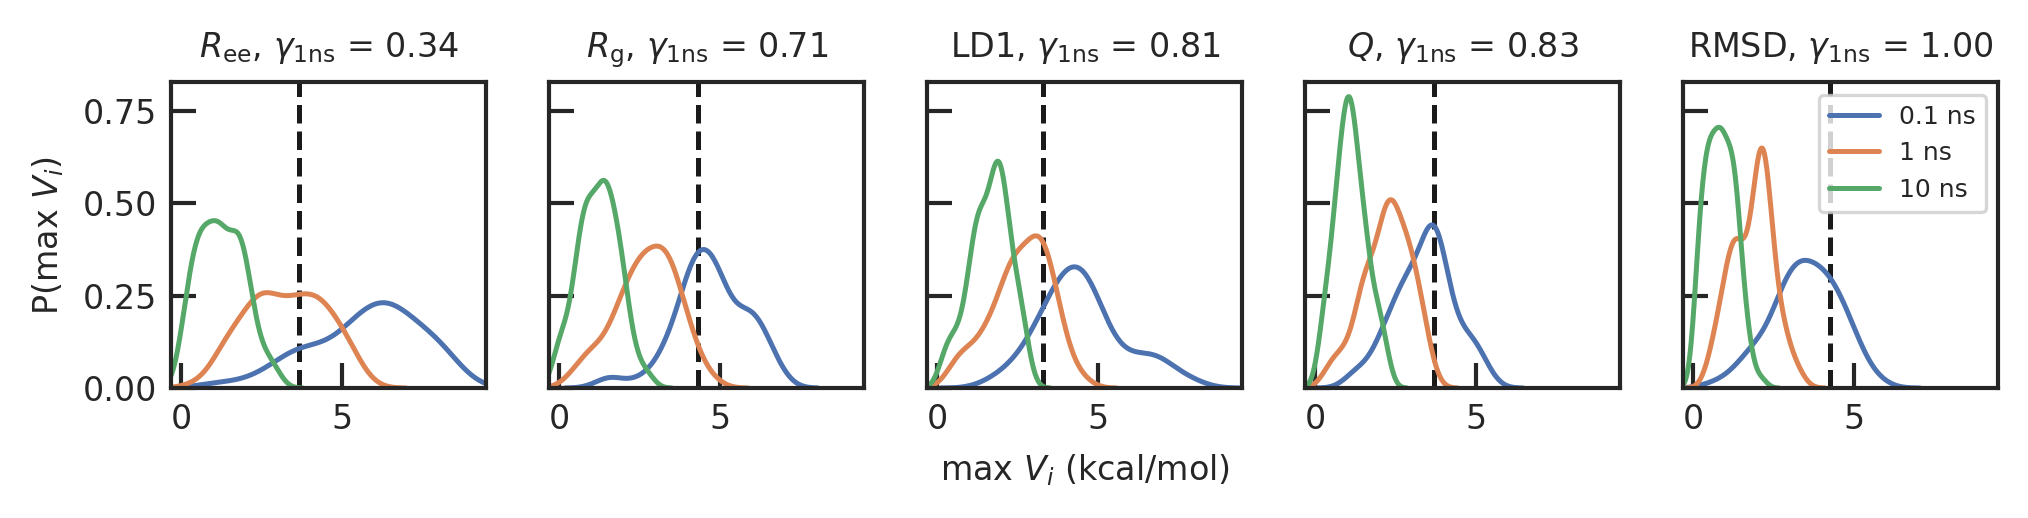

In [6]:
# This cell needs to be run twice to get the correct font sizes for the tick labels, for some reason.

sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 8, 'axes.linewidth': 1.0, 'lines.linewidth': 1.2, 'axes.titlesize': 8,
                             'xtick.labelsize': 8, 'ytick.labelsize': 8, 'xtick.major.width': 1.0, 'ytick.major.width': 1.0,
                             'legend.fontsize': 6, 'legend.framealpha': 0, 'lines.markersize': 4})

fig, axs = plt.subplots(1,5,sharex=True,sharey=True,figsize=(7,1.7),dpi=300)
fig.subplots_adjust(bottom=0.25,top=0.85,left=0.10,right=0.97)

#fig.add_subplot(111, frameon=False)
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("P($\max~V_i$)")

axs[0].axline((e_barrier,0),(e_barrier,0.35),linestyle='--',color='k')
sns.kdeplot(data=VMB_E1e4, legend=False, ax=axs[0])
sns.kdeplot(data=VMB_E1e5, legend=False, ax=axs[0])
sns.kdeplot(data=VMB_E1e6, legend=False, ax=axs[0])
axs[0].set_title('$R_{\mathrm{ee}}$, $\gamma_\mathrm{1ns}$ = 0.34')

axs[1].axline((g_barrier,0),(g_barrier,0.35),linestyle='--',color='k')
sns.kdeplot(data=VMB_G1e4, legend=False, ax=axs[1])
sns.kdeplot(data=VMB_G1e5, legend=False, ax=axs[1])
sns.kdeplot(data=VMB_G1e6, legend=False, ax=axs[1])
axs[1].set_title('$R_{\mathrm{g}}$, $\gamma_\mathrm{1ns}$ = 0.71')

axs[2].axline((l_barrier,0),(l_barrier,0.35),linestyle='--',color='k')
sns.kdeplot(data=VMB_L1e4, legend=False, ax=axs[2])
sns.kdeplot(data=VMB_L1e5, legend=False, ax=axs[2])
sns.kdeplot(data=VMB_L1e6, legend=False, ax=axs[2])
axs[2].set_title('LD1, $\gamma_\mathrm{1ns}$ = 0.81')
axs[2].set_xlabel("$\max~V_i$ (kcal/mol)")

axs[3].set_xlim((-0.3,9.5))
axs[3].axline((q_barrier,0),(q_barrier,0.35),linestyle='--',color='k')
sns.kdeplot(data=VMB_Q1e4, legend=False, ax=axs[3])
sns.kdeplot(data=VMB_Q1e5, legend=False, ax=axs[3])
sns.kdeplot(data=VMB_Q1e6, legend=False, ax=axs[3])
axs[3].set_title('$Q$, $\gamma_\mathrm{1ns}$ = 0.83')

axs[4].axline((r_barrier,0),(r_barrier,0.35),linestyle='--',color='k')
sns.kdeplot(data=VMB_R1e4, legend=False, ax=axs[4], label='0.1 ns')
sns.kdeplot(data=VMB_R1e5, legend=False, ax=axs[4], label='1 ns')
sns.kdeplot(data=VMB_R1e6, legend=False, ax=axs[4], label='10 ns')
axs[4].set_title('RMSD, $\gamma_\mathrm{1ns}$ = 1.00')
axs[4].legend()

for ax in axs:
    ax.tick_params(axis='both', direction='in', which='both', length=6)

plt.savefig("EATR_Fig4.pdf",format='pdf')